# Twitter US Airline Sentiment Analysis using NLP

In [1]:
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.snowball import SnowballStemmer #for stemming
from nltk.stem.porter import PorterStemmer #for stemming
from nltk.tokenize import TweetTokenizer #for tokenize 
from nltk.corpus import stopwords #for stopword
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from wordcloud import STOPWORDS, WordCloud

In [17]:
#load dataset
df = pd.read_csv('tweet.csv')

In [18]:
#display first 5 data
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### we only need text and airline_sentiment for the column to analyze it

In [36]:
#select 'text' and 'airline_sentiment'
df = pd.DataFrame(df[['text', 'airline_sentiment']])
#let us take a sample
df.sample(5)

,text,airline_sentiment
4269,is changing its mileageplus program winners a...,neutral
10932,nothing was available male flight crew was no...,negative
9347,i will never fly again,negative
11720,you are amazing you are the best follow me pl...,positive
7059,is there also a way i can get a printed one f...,neutral


In [37]:
#set all to lowercase
df['text'] = df['text'].str.lower()

In [38]:
#text cleaning
df['text'] = df['text'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])","")

In [39]:
#word tokenization
df['tokenized'] = df['text'].apply(nltk.word_tokenize)

In [51]:
#word stemming
ss = SnowballStemmer('english')
df['stemmed'] = df['tokenized'].apply(lambda list: [ss.stem(y) for word in list])

In [52]:
#let us take a look
df.head(5)

,text,airline_sentiment,tokenized,stemmed
0,what said,neutral,"[what, said]","[what, said]"
1,plus youve added commercials to the experienc...,positive,"[plus, youve, added, commercials, to, the, exp...","[plus, youv, ad, commerci, to, the, experi, ta..."
2,i didnt today must mean i need to take anothe...,neutral,"[i, didnt, today, must, mean, i, need, to, tak...","[i, didnt, today, must, mean, i, need, to, tak..."
3,its really aggressive to blast obnoxious ente...,negative,"[its, really, aggressive, to, blast, obnoxious...","[it, realli, aggress, to, blast, obnoxi, enter..."
4,and its a really big bad thing about it,negative,"[and, its, a, really, big, bad, thing, about, it]","[and, it, a, realli, big, bad, thing, about, it]"


In [68]:
#change a column name
df.rename(columns={'text':'raw_text'}, inplace=True)

#remove stopword
#stopwords = set(nltk.corpus.stopwords.words('english'))
#stopwords.update(['amp', 'cc', 'rt'])
#stopwords = stop - set(['no', 'not'])
stopwords = nltk.corpus.stopwords.words('english')
df['clean_text']=df['stemmed'].apply(lambda list: [word for word in list if word not in stopwords])

In [69]:
#let us take a look
df.head()

,raw_text,airline_sentiment,tokenized,stemmed,clean_text
0,what said,neutral,"[what, said]","[what, said]",[said]
1,plus youve added commercials to the experienc...,positive,"[plus, youve, added, commercials, to, the, exp...","[plus, youv, ad, commerci, to, the, experi, ta...","[plus, youv, ad, commerci, experi, tacki]"
2,i didnt today must mean i need to take anothe...,neutral,"[i, didnt, today, must, mean, i, need, to, tak...","[i, didnt, today, must, mean, i, need, to, tak...","[didnt, today, must, mean, need, take, anoth, ..."
3,its really aggressive to blast obnoxious ente...,negative,"[its, really, aggressive, to, blast, obnoxious...","[it, realli, aggress, to, blast, obnoxi, enter...","[realli, aggress, blast, obnoxi, entertain, gu..."
4,and its a really big bad thing about it,negative,"[and, its, a, really, big, bad, thing, about, it]","[and, it, a, realli, big, bad, thing, about, it]","[realli, big, bad, thing]"


In [70]:
#word detokenization
df['clean_text'] = df['clean_text'].str.join(" ")

In [78]:
#change a column order
df = df[['clean_text', 'airline_sentiment', 'raw_text', 'tokenized', 'stemmed']]
#let us take a look
df[['clean_text', 'airline_sentiment']].head()

,clean_text,airline_sentiment
0,said,neutral
1,plus youv ad commerci experi tacki,positive
2,didnt today must mean need take anoth trip,neutral
3,realli aggress blast obnoxi entertain guest fa...,negative
4,realli big bad thing,negative


In [87]:
#make a copy dataframe from existing dataframe
data = pd.DataFrame({'text': df['clean_text'], 'sentiment': df['airline_sentiment']})

In [94]:
#transforming positive into 2, neutral into 1 and negative into 0 via label encoding
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])

In [95]:
#let us take a look
data.head()

,text,sentiment
0,said,1
1,plus youv ad commerci experi tacki,2
2,didnt today must mean need take anoth trip,1
3,realli aggress blast obnoxi entertain guest fa...,0
4,realli big bad thing,0


In [98]:
#split  into train and test  
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size = 0.2, random_state = 1)

print("X_train: " + str(X_train.shape))
print("X_test: " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test: " + str(y_test.shape))

C:\Users\MOCH.REZA HABIBI\AppData\Local\conda\conda\envs\tensorflowsession\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


X_train: (11712,)
X_test: (2928,)
y_train: (11712,)
y_test: (2928,)


In [101]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
#fit and transform X_train
X_tr =  cv.fit_transform(X_train)
#transform X_test
X_ts = cv.transform(X_test)

In [143]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_tr, y_train)
clf.score(X_ts, y_test)

0.6970628415300546

#### we will try to improve on it

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=100,
    learning_rate=1, random_state=4)
adb.fit(X_tr, y_train)
adb.score(X_ts, y_test)

0.7349726775956285

#### we will try to improve on it again

In [158]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_fit = lr.fit(X_tr, y_train)
cross_val_score(lr_fit, X_ts, y_test, cv=5).mean()

0.7486132914704344

#### we will try to improve on it once more

In [156]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_tr, y_train)
mnb.predict(X_ts)
mnb.score(X_ts, y_test)

0.7667349726775956

#### OK let us move to the visualization of the dataset

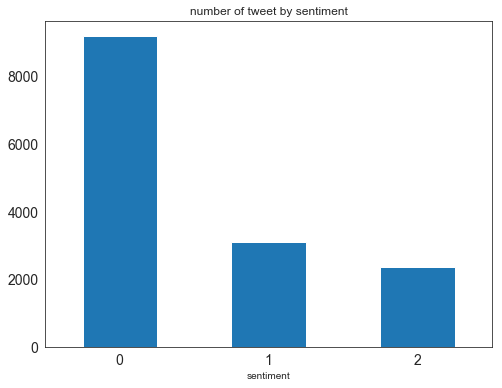

In [329]:
#count and plot number of tweet by sentiment
data.groupby(['sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='number of tweet by sentiment');

In [192]:
#load dataset
new_df = pd.read_csv('tweet.csv')

In [197]:
#count number of tweet by airline
new_df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

([<matplotlib.axis.XTick at 0x192a85b0e10>,
 <a list of 6 Text xticklabel objects>)

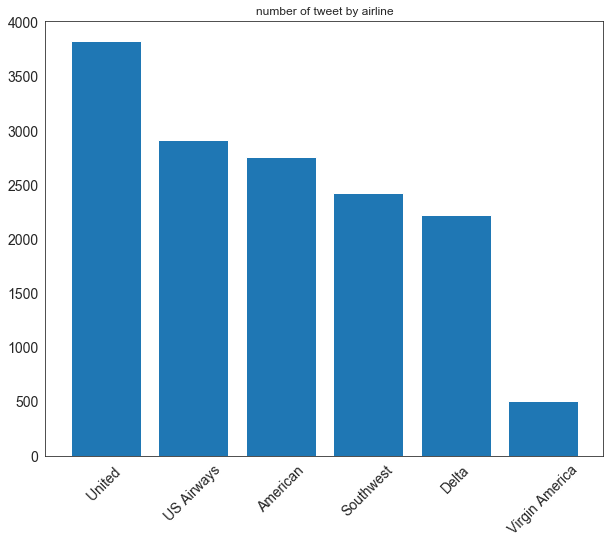

In [330]:
#plot number of tweet by sentiment

plt.figure(figsize = (10,8))
plt.bar([1,2,3,4,5,6], new_df['airline'].value_counts())
plt.title("number of tweet by airline")
plt.xticks([1,2,3,4,5,6], ['United ','US Airways','American','Southwest','Delta','Virgin America'], rotation = 45)


plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='white')

In [275]:
#list negative reason and drop NaN value
negative_reason = new_df['negativereason'].dropna()
#count number of tweet by negative reason
negative_reason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

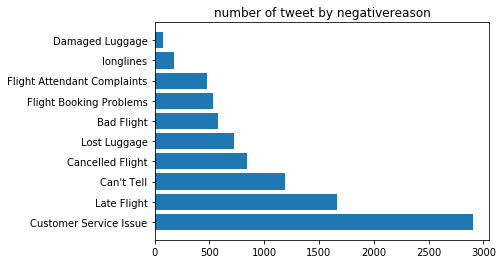

In [302]:
#plot number of tweet by negative reason
plt.barh(range(len(negative_reason.unique())), [val for val in negative_reason.value_counts().tolist()], align='center')
plt.title("number of tweet by negativereason")
plt.yticks(range(len(negative_reason.unique())), [val for val in negative_reason.value_counts().index.tolist()])
plt.show()

#plt.figure(figsize=(10,8))
#plt.bar(range(1,len(negative_reason.unique())+1), negative_reason.value_counts())
#plt.title("number of tweet by negativereason")
#plt.xticks(range(1,len(negative_reason.unique())+1), negative_reason.value_counts().index.tolist(), rotation = 90)

In [356]:
def reason_each_flight(airline):
    new_data = new_df[new_df['airline'] == airline]
    new_data = new_data['negativereason']
    new_data_count = new_data.value_counts()
    plt.barh(range(1,(len(new_data.unique()))), new_data_count)
    plt.title('number of tweet by negative sentiment for ' + airline)
    plt.yticks(range(1,(len(new_data.unique()))), new_data.value_counts().index.tolist())
    
    #index = range(1,(len(new_data.unique()))) 
    #list = new_data.value_counts().index.tolist()
    #plt.bar(range(1,(len(new_data.unique()))), new_data_count)
    #plt.title('Total number of Time Negative Tweets for ' + airline)
    #plt.xticks(range(1,(len(new_data.unique()))), new_data.value_counts().index.tolist(), rotation = 90)

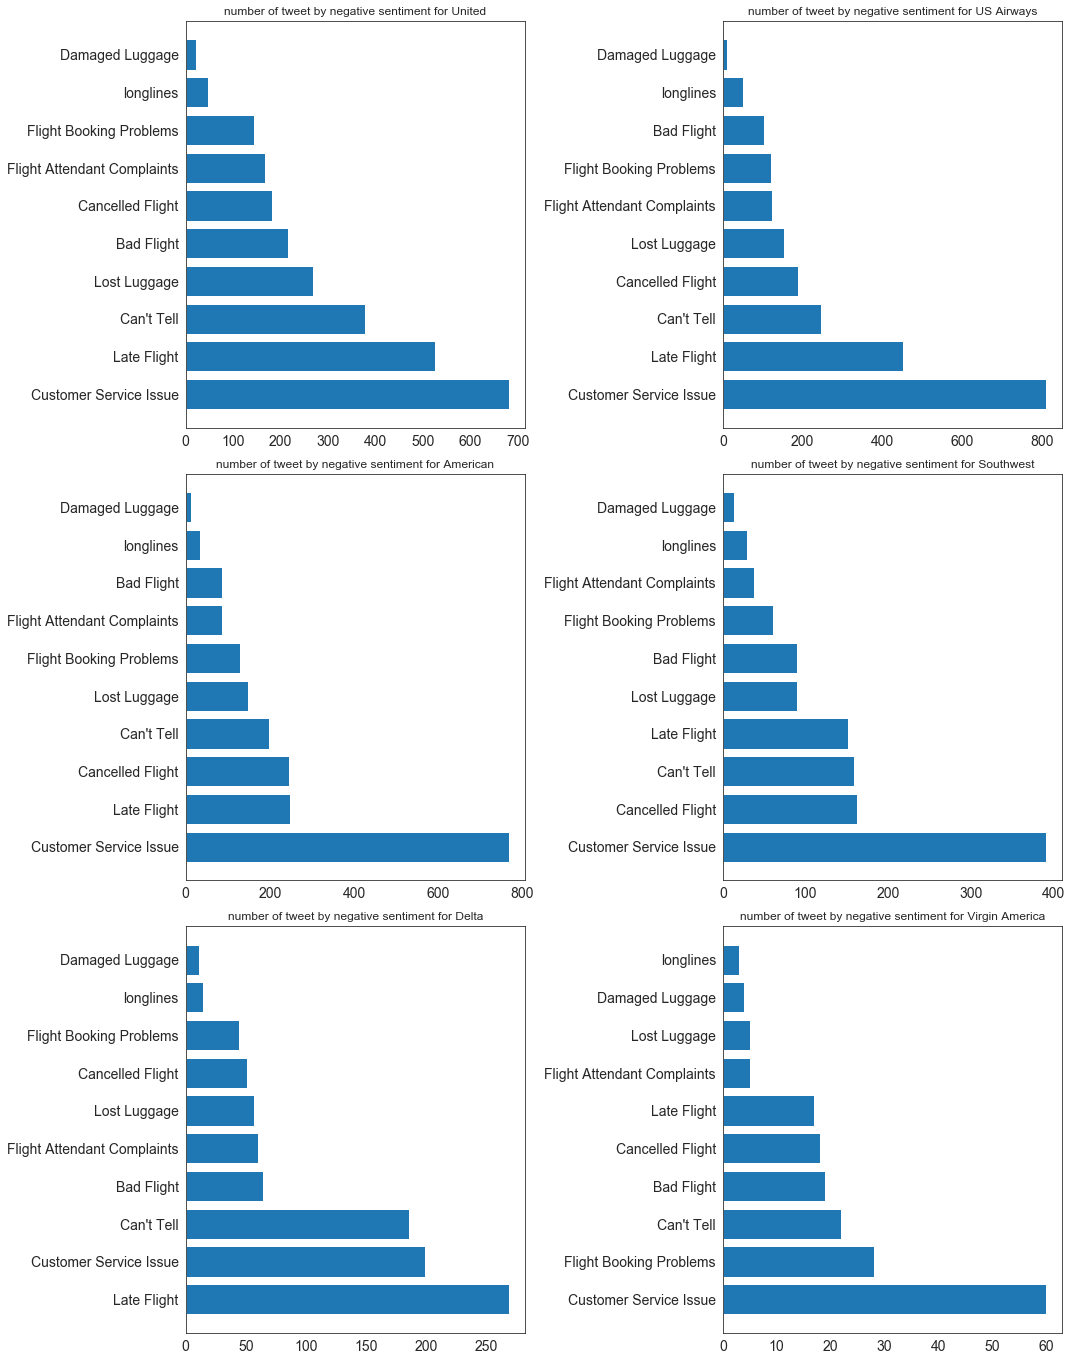

In [357]:
#count and plot number of tweet by negative sentiment for each airline
Air = new_df['airline'].value_counts().index.tolist()
plt.figure(1,figsize=(15, 25))
plt.subplot(421)
reason_each_flight(Air[0])
plt.subplot(422)
reason_each_flight(Air[1])
plt.subplot(423)
reason_each_flight(Air[2])
plt.subplot(424)
reason_each_flight(Air[3])
plt.subplot(425)
reason_each_flight(Air[4])
plt.subplot(426)
reason_each_flight(Air[5])
plt.tight_layout()

In [232]:
#count number of tweet by 5 most common word
tk = Tokenizer()
tk.fit_on_texts(data['text'])
word_count = collections.Counter(tk.word_counts).most_common(5)
word_count

[('flight', 4815),
 ('thank', 1688),
 ('get', 1617),
 ('hour', 1150),
 ('cancel', 1056)]

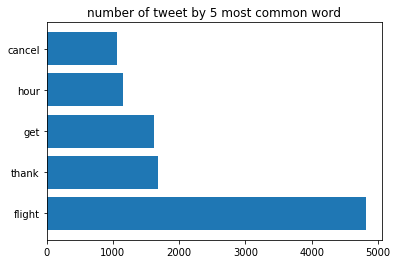

In [304]:
#plot number of tweet by 5 most common word
plt.barh(range(len(word_count)),[val[1] for val in word_count], align='center')
plt.title("number of tweet by 5 most common word")
plt.yticks(range(len(word_count)), [val[0] for val in word_count])
plt.show()

#plt.figure(figsize=(10,8))
#plt.bar([1,2,3,4,5], [count for word,count in word_count])
#plt.title("number of tweet by 5 most common word")
#plt.xticks([1,2,3,4,5], ['flight','thank','get','hour','cancel'])

In [323]:
def get_token_coefs(vocab, coef, n):
    coefs_df = pd.DataFrame({'vocabs': vocab, 'coefs':coef.reshape(-1)})
    return coefs_df.sort_values('coefs', ascending=False).reset_index(drop=True)[:n]

def plot_token_coefs(df, ax, label):
    df.sort_values('coefs').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocabs'].values.tolist()[::-1])
    ax.set_title(label);

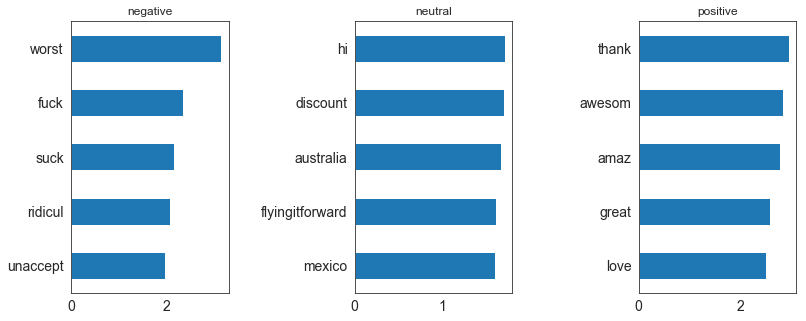

In [348]:
#count and plot number of tweet by 5 most common word in each sentiment

vocab = cv.get_feature_names()
n_coef = 5

fig, axs = plt.subplots(1, 3, figsize=(13, 5))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['negative', 'neutral', 'positive']):
    coefs_df = get_token_coefs(vocab, lr.coef_[i], n_coef)
    plot_token_coefs(coefs_df, axs[i], l)

#### OK let us make a wordcloud now

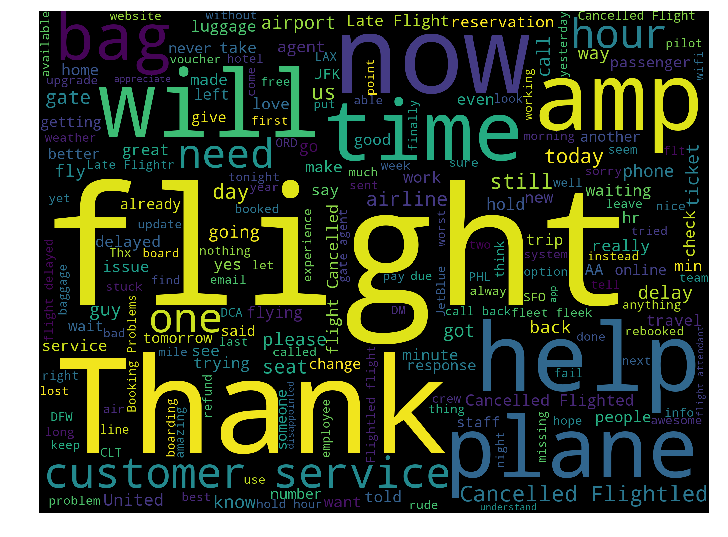

In [23]:
new_data=new_df[new_df['airline_sentiment']=='positive']

#join tweet to a single string
words = ' '.join(new_df['text'])

#remove URL, RT, and twitter @ and twitter handle
no_tag = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2000,
                      height=1500).generate(no_tag)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

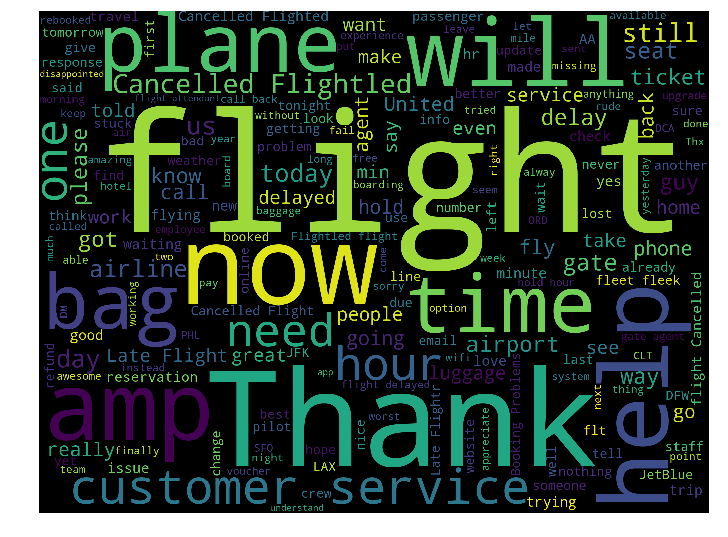

In [22]:
new_data=new_df[new_df['airline_sentiment']=='negative']

#join tweet to a single string
words = ' '.join(new_df['text'])

#remove URL, RT, and twitter @ and twitter handle
no_tag = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=2000,
                      height=1500).generate(no_tag)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()